<a href="https://colab.research.google.com/github/amaye15/CanineNet/blob/main/code/ModelFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model From Scratch

In [1]:
%pip install datasets==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00


In [2]:
import io
import cv2
import datasets
import torch

from PIL import Image
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pyarrow_hotfix

from functools import partial


pyarrow_hotfix.uninstall()

# Load the dataset
dataset = datasets.load_dataset("Alanox/stanford-dogs", split="full").train_test_split(test_size=0.3) #, streaming=True)

target_df = datasets.load_dataset("Alanox/stanford-dogs", split="full").remove_columns(["name", "annotations", "image"]).to_pandas().value_counts().reset_index().reset_index().rename(columns={"index": "label", 0: "count"})

def display_random_images(dataset, key = "image", number_of_images=9, image_size=(128, 128), grid_size=(3, 3)):
    """
    Displays a specified number of random images from a Hugging Face dataset in a grid layout.

    Parameters:
    dataset: The dataset to use.
    number_of_images (int): The number of images to display.
    image_size (tuple): The size (width, height) to which each image will be resized.
    grid_size (tuple): The grid size (rows, columns) for displaying the images.
    """

    # Shuffle the dataset
    shuffled_dataset = dataset.shuffle(seed=np.random.randint(0, 1000))

    # Determine the number of rows and columns in the grid
    rows, cols = grid_size

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, ax in enumerate(axes):
        if i < number_of_images:
            # Decode and resize the image
            image_data = shuffled_dataset[i][key]
            image = image_data
            image = image.resize(image_size)

            # Display the image
            ax.imshow(image)
            ax.axis('off')
        else:
            # Hide extra subplots if the number of images is less than grid cells
            ax.axis('off')

    plt.tight_layout()
    plt.show()


#display_random_images(dataset)

Generating full split: 0 examples [00:00, ? examples/s]

In [3]:
from torchvision.transforms import v2

def transforms(examples, transformation_function, to_tensor, target_mapping = None):
    if to_tensor:
      examples["image"] = [v2.functional.pil_to_tensor(transformation_function(image.convert("RGB"))) for image in examples["image"]]
      examples["target"] = [target_mapping[target] for target in examples["target"]]
      examples.pop("name")
      examples.pop("annotations")

    else:
      examples["image"] = [transformation_function(image.convert("RGB")) for image in examples["image"]]
    return examples

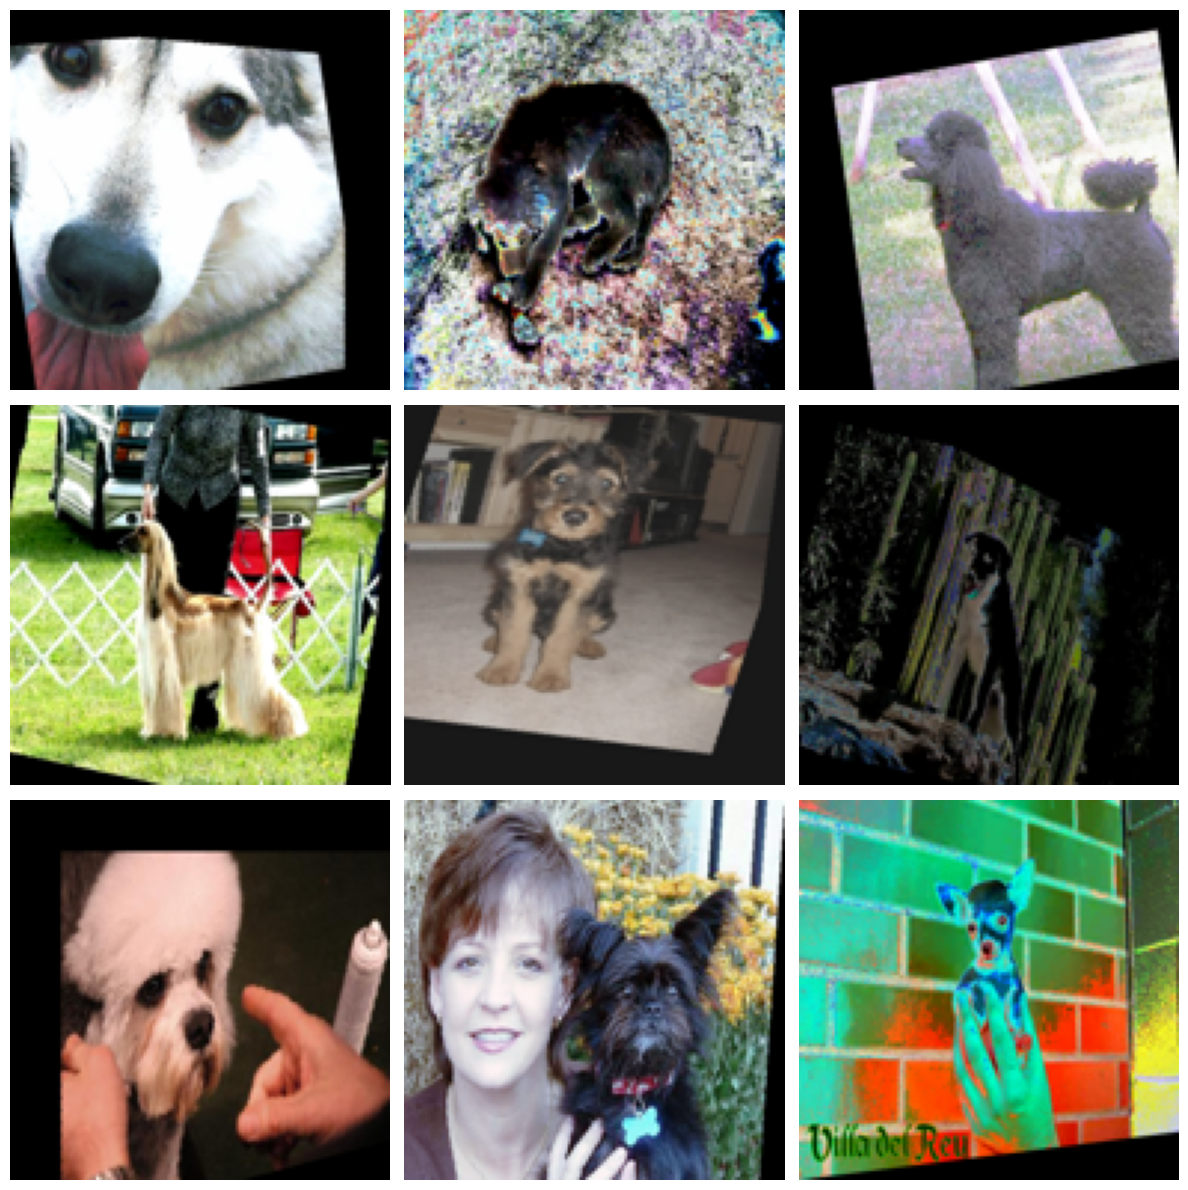

In [84]:
image_size = (256, 256)
transformation = v2.Compose([v2.RandAugment(num_ops = 10), v2.Resize(size = image_size)])
#v2.RandAugment(num_ops = 10)


dataset.set_transform(partial(transforms, transformation_function = transformation, to_tensor = False))
display_random_images(dataset["train"], key = "image")

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, conv_layers, fc_layers, input_size, dropout_rates=None, activation_fn=F.relu, pool_fn=nn.MaxPool2d(kernel_size=2, stride=2)):
        super(CNN, self).__init__()
        self.activation_fn = activation_fn
        self.pool_fn = pool_fn

        self.conv_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        last_channels = input_size[0]
        output_size = input_size[1:]

        for i, (in_channels, out_channels, kernel_size, padding) in enumerate(conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
            output_size = [((size + 2 * padding - (kernel_size - 1) - 1) // 2) + 1 for size in output_size]  # Calculate output size
            last_channels = out_channels
            if dropout_rates and i < len(dropout_rates):
                self.dropouts.append(nn.Dropout(dropout_rates[i]))
            else:
                self.dropouts.append(nn.Identity())  # No dropout

        flatten_size = last_channels * output_size[0] * output_size[1]
        self.fc_layers = nn.ModuleList()
        for out_features in fc_layers:
            self.fc_layers.append(nn.Linear(flatten_size, out_features))
            flatten_size = out_features

    def forward(self, x):
        for conv, dropout in zip(self.conv_layers, self.dropouts):
            x = dropout(self.pool_fn(self.activation_fn(conv(x))))

        x = x.view(x.size(0), -1)  # Flatten

        for i, fc in enumerate(self.fc_layers):
            x = self.activation_fn(fc(x))
            if i < len(self.fc_layers) - 1:
                x = self.dropouts[i](x)  # Apply corresponding dropout

        return x

# Example usage
# model = CNN(
#     conv_layers=[(3, 32, 3, 1), (32, 64, 3, 1), (64, 32, 3, 1), (32, 16, 3, 1)],
#     fc_layers=[128, target_df.shape[0]],
#     input_size=(3, 256, 256),  # Assuming input size of 224x224 with 3 channels
#     dropout_rates=[0.25, 0.25, 0.5]
# )

#output = model(torch.randn(32, 3, 256, 256))  # Example input tensor



In [86]:
dataset.set_transform(partial(transforms,
                              transformation_function = transformation,
                              to_tensor = True,
                              target_mapping = dict(zip(target_df["target"].to_dict().values(), target_df["target"].to_dict().keys()))))


In [108]:
  image_size = (256, 256)
  transformation = v2.Compose([v2.Resize(size = image_size), v2.RandAugment(num_ops = 10), v2.Resize(size = image_size)])

  dataset.set_transform(partial(transforms,
                              transformation_function = transformation,
                              to_tensor = True,
                              target_mapping = dict(zip(target_df["target"].to_dict().values(), target_df["target"].to_dict().keys()))))

In [6]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Model Config
convLayers = [(3, 32, 3, 1), (32, 64, 3, 1), (64, 32, 3, 1), (32, 16, 3, 1)]
fcLayers = [128, target_df.shape[0]]
imageSize = (3, 256, 256)
dpRates = [0.25, 0.25, 0.5]

# Model
model = CNN(conv_layers = convLayers, fc_layers = fcLayers, input_size = imageSize, dropout_rates = dpRates)

# Criteria & Optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train Config
EPOCHS = 100
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
image_size = (256, 256)
OPS = 10

model.to(DEVICE)

for epoch in range(EPOCHS):
  transformation = v2.Compose([v2.RandAugment(num_ops = OPS), v2.Resize(size = image_size)])

  dataset.set_transform(partial(transforms,
                                transformation_function = transformation,
                                to_tensor = True,
                                target_mapping = dict(zip(target_df["target"].to_dict().values(),
                                                          target_df["target"].to_dict().keys()))))
  # Train
  model.train()
  for batch in DataLoader(dataset["train"], batch_size = BATCH_SIZE, shuffle = True):
    optimizer.zero_grad()

    output = model(batch["image"].float().to(DEVICE))

    loss = criterion(output, batch["target"].to(DEVICE))
    print("Train loss: ", loss)

  # Test
  model.eval()
  with torch.no_grad():
    for batch in DataLoader(dataset["test"], batch_size = BATCH_SIZE, shuffle = False):
      optimizer.zero_grad()

      output = model(batch["image"].float().to(DEVICE))

      loss = criterion(output, batch["target"].to(DEVICE))
      print("Test loss: ", loss)



Train loss:  tensor(11.7433, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.1483, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(12.9675, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(12.9699, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(12.9961, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(14.0693, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(12.8361, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(11.8193, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(12.0517, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(12.5304, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(11.7155, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(12.9692, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(13.4229, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(12.9565, device='c

KeyboardInterrupt: 